# A brief introduction to Transformers for neural data

We will use [nanoGPT](https://github.com/karpathy/nanoGPT) for these examples. __Despite the reputation that Transformers are specifically language models, they are in-fact state of the art for a shockingly wide range of problems.__ nanoGPT provides a [great reference implementation](https://github.com/karpathy/nanoGPT/blob/master/model.py) which can be easily adapted beyond LLM use.

For this demo we will use a modified version of model.py which removes LLM-specific elements.

The original Transformers paper is ["Attention is All You Need" (Vaswani et al. 2017)](https://arxiv.org/abs/1706.03762).

## Transformers fundamentally involve 'attention' across sequence elements

"Attention" means we interpret a sequence element using contextual information contained in the other sequence elements.

<div>
<img src="attachment:B17123_01_18.png" width="500"/>
</div>

## Transformers' attention operates on continuous spaces

Despite appearances, attention mechanisms have nothing _per se_ to do with language. In fact they usually operate in continuous vector spaces, typically implemented by tensors of floating point numbers.

So how are we using them for language? In brief: __we map language tokens to continuous spaces using _word embeddings___. One example: [word2vec](https://en.wikipedia.org/wiki/Word2vec).

Great visualization [here](https://projector.tensorflow.org/)!

## Positional encoding tells the Transformer where each sequence element is located
The Transformer's attention mechanism can't determine the relative position of the elements in the sequence. So: we sum in some additional information which communicates the position in the sentence / image / volume / etc.

One approach would be appending the sequence index to each sequence element. That is perhaps less likely to interfere with the original features. In trade-off you would need more memory. Let's use the "sum in the position" method, since that is appears in the original Transformers paper.

<div>
<img src="attachment:pe.png" width="700"/>
</div>


There is an [off-the-shelf Pytorch solution](https://pypi.org/project/positional-encodings/). It can be installed with:

```pip install positional-encodings[pytorch]```

## No reason that can't include 2D positions!

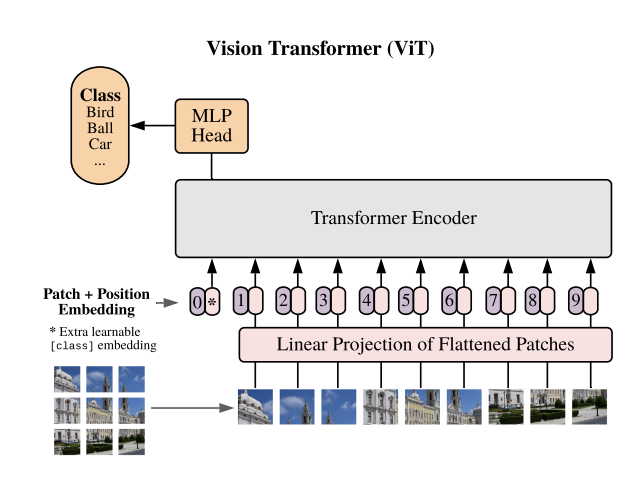

(Vision transformers - Dosovitskiy & Google, 2020)

# Neural example: predict a reach target from eCog data

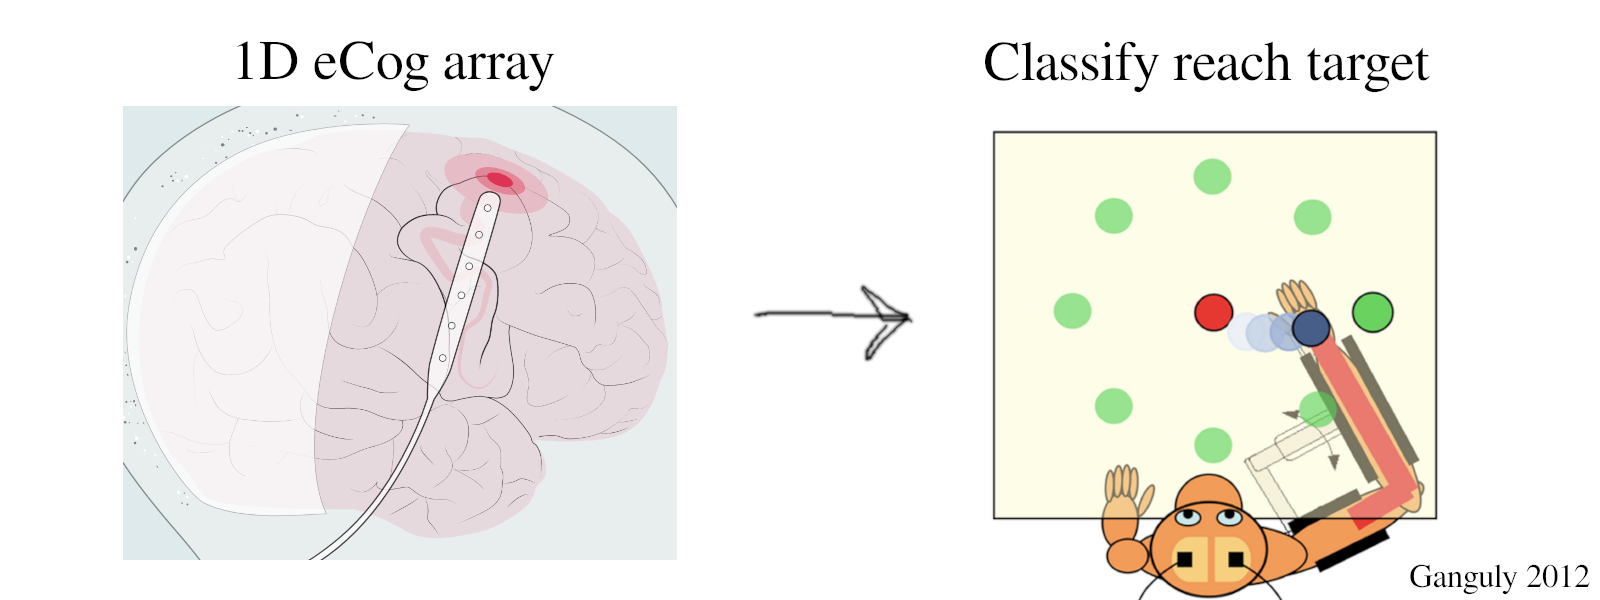

### Question: what is the sequence dimension, what is the feature dimension?


In [1]:
%load_ext autoreload
%autoreload 2

from positional_encodings.torch_encodings import PositionalEncoding1D, Summer
import torch

import model


# Just tiny numbers for the demo...
BATCH_SIZE = 45
EPOCH_LEN = 10   # In "time steps"
NUM_ELECTRODES = 6
NUM_TARGETS = 8


# Set this to "cpu" for main memory and CPU use
# Set this to "cuda" for GPU use
# You can select a specific GPU with e.g. "cuda:0"
CUDA = "cuda:0"

In [2]:
import numpy as np
data = np.load('data.npy')
labels = np.load('labels.npy')
labels = labels[:, 0]

In [3]:
print("data shape:", data.shape)
print("labels shape:", labels.shape)

data shape: (8999, 200)
labels shape: (8999,)


In [4]:
# reshape window
# Parameters
window_size = 10
num_samples, num_features = data.shape
# num_labels = labels.shape[1]

# Calculate the number of windows (overlapping windows)
num_windows = num_samples - window_size + 1

# Initialize the new dataset
windows = np.zeros((num_windows, window_size, num_features))
window_labels = np.zeros((num_windows, window_size))

# Fill the windows and window_labels with the data
for i in range(num_windows):
    windows[i] = data[i:i + window_size]
    window_labels[i] = labels[i:i + window_size]

# Convert to PyTorch tensors
windows = torch.tensor(windows)
window_labels = torch.tensor(window_labels)

print(windows.shape)  # Output: (8990, 10, 200)
print(window_labels.shape)  # Output: (8990, 10, 6)

torch.Size([8990, 10, 200])
torch.Size([8990, 10])


In [5]:
from torch.utils.data import DataLoader, random_split, TensorDataset
# data_tensor = torch.tensor(data)
# labels_tensor = torch.tensor(labels)
data = TensorDataset(windows, window_labels)


In [6]:
# divide into train, valid, test
train_size = int(0.7 * len(data))
val_size = int(0.15 * len(data))
test_size = len(data) - train_size - val_size
train_data, val_data, test_data = random_split(data, [train_size, val_size, test_size])

In [7]:
# # Prep some fake eCog data

# # Inputs: (batch, electrode, time)
# ecog = torch.rand(BATCH_SIZE, NUM_ELECTRODES, EPOCH_LEN)

# # Positional encoding across *time*: this lib encodes along the last dimension
# summer = Summer(PositionalEncoding1D(EPOCH_LEN))
# ecog_pe = summer(ecog)

# # Transformer implementation expects (batch, time, electrode)
# ecog_pe = ecog_pe.permute(0, 2, 1).to(CUDA)
# print(ecog_pe.shape)

In [8]:
# prep eeg data
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [9]:
# check the shape of data and target in one batch
for inputs, targets in train_loader:
    print(f"Inputs shape: {inputs.shape}")
    print(f"Targets shape: {targets.shape}")
    break

Inputs shape: torch.Size([32, 10, 200])
Targets shape: torch.Size([32, 10])


In [10]:
# # Prep some class labels

# # Targets: (batch, num targets (one hot encoded))
# labels = torch.tensor([[bidx % EPOCH_LEN for _ in range(EPOCH_LEN)] for bidx in range(BATCH_SIZE)])
# print(labels.shape)
# # labels_oh = torch.nn.functional.one_hot(labels, num_classes=NUM_TARGETS).type(
# #          torch.FloatTensor
# # ).to(CUDA)
# labels_oh = labels.type(torch.FloatTensor).to(CUDA)

In [11]:
# Make a Transformer!

# NOTE: num_heads must divide input_size!
num_heads = 4

num_layers = 2
NUM_ELECTRODES = 200
EPOCH_LEN = 10
xformer, optim = model.get_transformer(
    input_size=NUM_ELECTRODES,
    num_layers=num_layers,
    num_heads=num_heads,
    n_embd=NUM_ELECTRODES,
    out_dim=EPOCH_LEN,
    trial_len=EPOCH_LEN,
    cuda=CUDA
)

In [12]:
# Let's train
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
       
        inputs = inputs.type(torch.FloatTensor).to(CUDA)
        targets = targets.type(torch.FloatTensor).to(CUDA)
        optim.zero_grad()
        y_hat = xformer(inputs)

        # print("y_hat:", y_hat.shape)
        # print("targets:", targets.shape)

        loss = torch.nn.MSELoss()(y_hat, targets)
        loss.backward()
        optim.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    #validation
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.type(torch.FloatTensor).to(CUDA)

            targets = targets.type(torch.FloatTensor).to(CUDA)
            y_hat = xformer(inputs)

            loss = torch.nn.MSELoss()(y_hat, targets)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss:.4f}")



Epoch [1/10], Loss: 52.0236
Validation Loss: 2152.1739
Epoch [2/10], Loss: 49.8214
Validation Loss: 2129.0836
Epoch [3/10], Loss: 48.8108
Validation Loss: 2115.3470
Epoch [4/10], Loss: 47.3346
Validation Loss: 2144.8018
Epoch [5/10], Loss: 45.4340
Validation Loss: 2012.3997
Epoch [6/10], Loss: 43.0439
Validation Loss: 1960.1337
Epoch [7/10], Loss: 40.3514
Validation Loss: 1889.4183
Epoch [8/10], Loss: 37.8074
Validation Loss: 1882.6770
Epoch [9/10], Loss: 34.7833
Validation Loss: 1728.5399
Epoch [10/10], Loss: 31.9047
Validation Loss: 1678.1567


In [5]:
# Let's train!

# for eidx in range(100):
#     # y_hat contains class probabilities. It's the same shape as target_oh.
#     y_hat = xformer(ecog_pe)
#     print("y_hat:", y_hat.shape)
#     print("labels_oh:", labels_oh.shape)

#     loss = torch.nn.MSELoss()(y_hat, labels_oh)  # changed loss function
#     loss.backward()
#     optim.step()
#     print(eidx, loss)
    


y_hat: torch.Size([45, 10])
labels_oh: torch.Size([45, 10])
0 tensor(25.9760, device='cuda:0', grad_fn=<MseLossBackward0>)
y_hat: torch.Size([45, 10])
labels_oh: torch.Size([45, 10])
1 tensor(25.8912, device='cuda:0', grad_fn=<MseLossBackward0>)
y_hat: torch.Size([45, 10])
labels_oh: torch.Size([45, 10])
2 tensor(25.8061, device='cuda:0', grad_fn=<MseLossBackward0>)
y_hat: torch.Size([45, 10])
labels_oh: torch.Size([45, 10])
3 tensor(25.7184, device='cuda:0', grad_fn=<MseLossBackward0>)
y_hat: torch.Size([45, 10])
labels_oh: torch.Size([45, 10])
4 tensor(25.6269, device='cuda:0', grad_fn=<MseLossBackward0>)
y_hat: torch.Size([45, 10])
labels_oh: torch.Size([45, 10])
5 tensor(25.5306, device='cuda:0', grad_fn=<MseLossBackward0>)
y_hat: torch.Size([45, 10])
labels_oh: torch.Size([45, 10])
6 tensor(25.4274, device='cuda:0', grad_fn=<MseLossBackward0>)
y_hat: torch.Size([45, 10])
labels_oh: torch.Size([45, 10])
7 tensor(25.3149, device='cuda:0', grad_fn=<MseLossBackward0>)
y_hat: torch.Siz

## Cross attention allows for translation between types of data.

#### LLM examples
* translation between written languages
* translation from question to answer

#### Possible neural example
* translate brain activity to written speech

## Example: question and answer LLM (i.e. like ChatGPT)

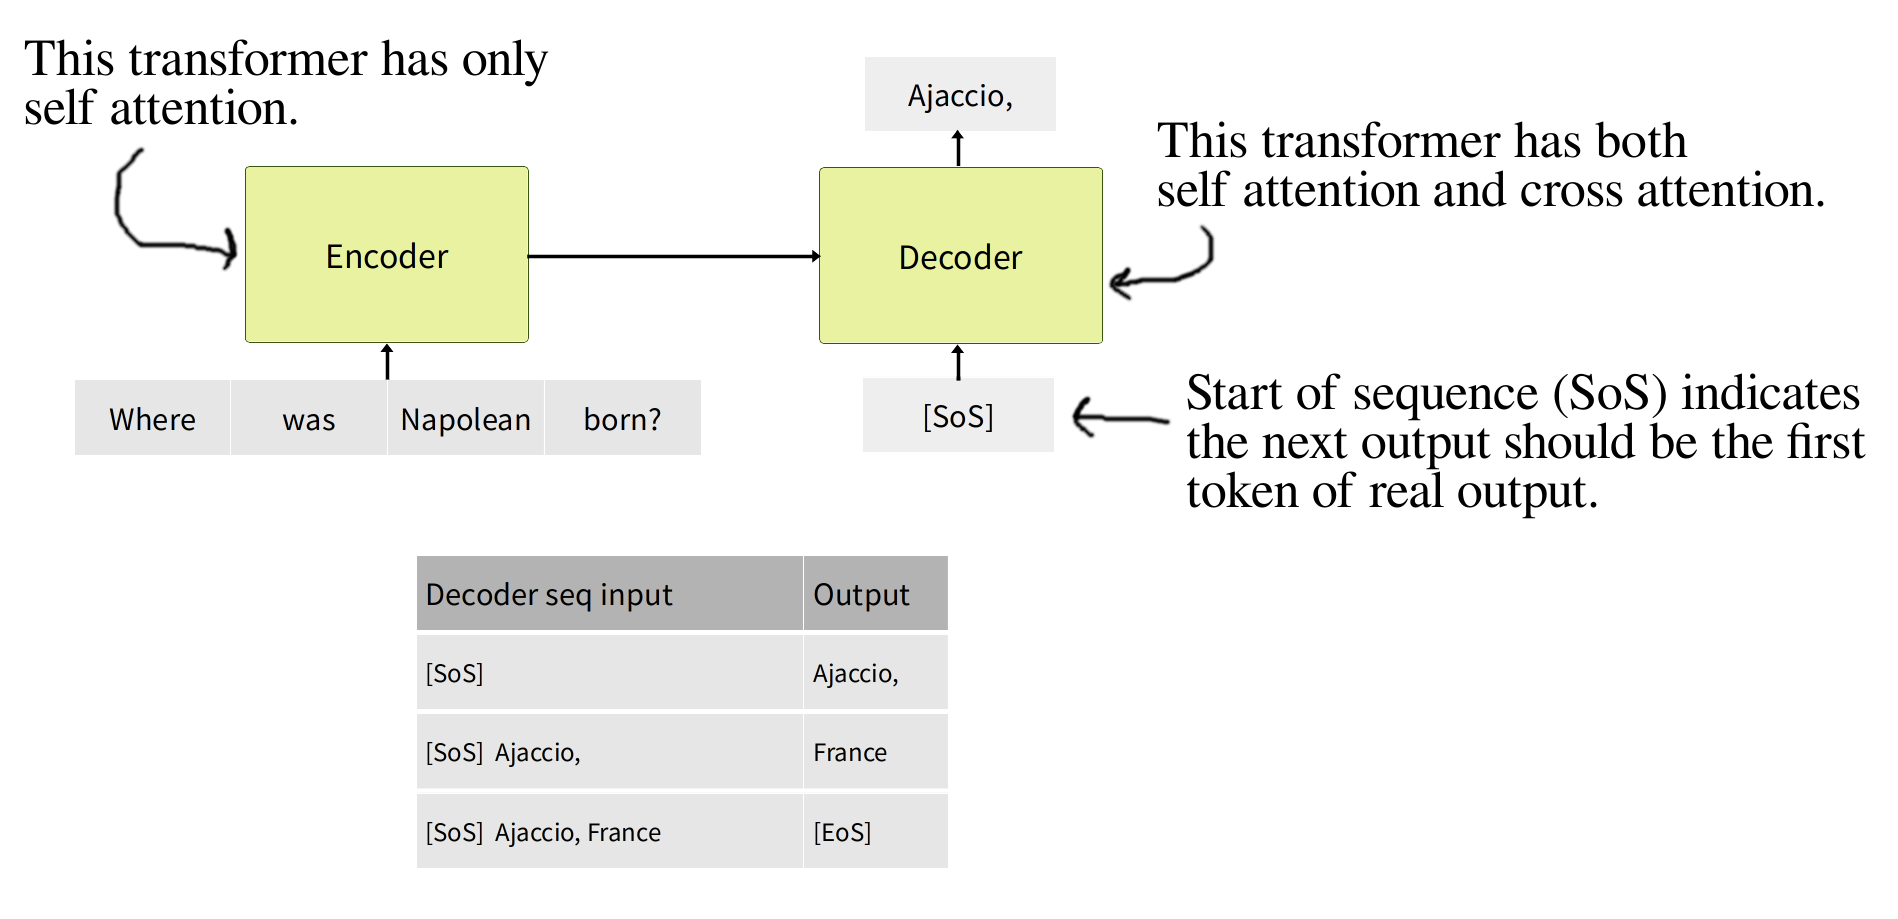

This architecture is fundamentally about generating sequences of language tokens. It generates tokens from the start of the response to the end. It uses two attention mechanisms to do that:
* an _acausal_ cross-attention mechanism which examines all the tokens in the question; and
* a _causal_ self-attention mechanism which examines all the tokens generated thus far.

Initially the response is empty, and consists of only a start of sequence (SoS) token. Each pass through the network adds an additional token. The sequence generated thus far is fed back in as the input over which causal attention is paid. This proceeds until the model outputs a special end of sequence (EoS) token.

Let's skip building one of these for now, since it will take some Pytorch work.

# Notes on the provided model.py
Since this file is a sort-of fork of nanoGPT, it's crucial to understand the changes and what they mean for your project. One size does not fit all.

The most substantive changes are as follows:
* The auto embedding layers have been disabled. You can search for "Embedding" in the file to see where the related calls are. Instead, it is assumed the user will perform any embedding themselves as needed.
* Depending on your use case you may want causal or acausal attention. Look for this line and change it as needed: is_causal=False
* Right now it is assumed you are running on a system + Pytorch version with [a high performance attention mechanism](https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html) available. If you hit errors here, you may want to roll back to [use a manual implementation](https://github.com/karpathy/nanoGPT/blob/master/model.py#L62C1-L71C75).
* The outputs were assumed to be discrete before (e.g. from a dictionary). That assumption has been relaxed.